<a href="https://colab.research.google.com/github/Matheus008/BibliotecaSenai/blob/main/Bootcamp_AnaliseDeDadosComIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Python - Bootcamp IA
Uma empresa do setor industrial contatou você para a criação de um sistema inteligente de
manutenção preditiva das suas diferentes máquinas. Essa empresa forneceu um conjunto de
dados contendo informações coletadas a partir de dispositivos IoT sensorizando atributos
básicos de cada máquina. O objetivo é criar um sistema capaz de identificar as falhas que
venham a ocorrer, e se possível, qual foi o tipo da falha. Cada amostra no conjunto de dados é
composta por 8 atributos que descrevem o comportamento de desgaste da máquina e do
ambiente. Além dessas características, cada amostra é rotulada com uma das 5 possíveis
classes de defeitos.
O sistema deverá ser capaz de, a partir de uma nova medição do dispositivo IoT (ou conjunto
de medições), prever a classe do defeito e retornar a probabilidade associada. Além disso, a
empresa espera que você extraia insights da operação e dos defeitos e gere visualizações de
dados.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, hamming_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier

## Importar a base de dados

In [ ]:
tabela_train = pd.read_csv("bootcamp_train.csv")

## Visualizar e analisar os dados da tabela

verificar inconsistencias da tabela

In [ ]:
tabela_train.sample(10)

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
19612,19612,M18811,M,302.3,311.4,90.0,1442.0,49.3,17.0,Não,False,False,Não,False,Não
30219,30219,L49193,L,298.6,308.4,90.0,1356.0,45.1,38.0,Não,False,False,Não,False,Não
27823,27823,M17124,M,299.2,308.4,90.0,1585.0,43.5,181.0,não,False,False,Não,False,Não
19519,19519,L55686,L,298.5,309.6,90.0,1572.0,37.0,-202.0,Não,False,False,Não,False,não
23892,23892,L53535,L,300.1,309.7,90.0,1481.0,39.4,34.0,não,False,False,Não,False,Não
3427,3427,M21802,M,300.8,311.4,90.0,1732.0,26.9,45.0,Não,False,False,Não,False,não
24530,24530,L53256,L,301.0,310.9,90.0,1492.0,47.3,199.0,não,False,False,não,False,Não
9912,9912,L48499,L,297.1,-38.0,90.0,1460.0,49.8,113.0,Não,False,False,Não,False,Não
9423,9423,L49079,L,-36.0,307.5,90.0,1418.0,40.0,159.0,Não,False,False,não,False,não
10883,10883,L57043,L,298.9,309.9,90.0,1352.0,56.3,84.0,Não,False,False,não,False,não


In [ ]:
tabela_train.tail()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
35255,35255,L54709,L,300.1,311.4,90.0,1634.0,34.2,45.0,não,False,False,não,False,Não
35256,35256,L54735,L,300.4,311.3,90.0,1597.0,36.2,112.0,0,False,False,Não,False,Não
35257,35257,L54275,L,300.6,-38.0,90.0,1485.0,35.8,19.0,Não,False,False,Não,False,Não
35258,35258,M18165,M,301.3,310.4,90.0,1577.0,37.3,43.0,não,False,False,não,False,não
35259,35259,L53432,L,300.8,310.3,90.0,1438.0,44.1,198.0,Não,False,False,não,False,Não


Verificar os Dtypes

In [ ]:
tabela_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35260 entries, 0 to 35259
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               35260 non-null  int64  
 1   id_produto                       35260 non-null  object 
 2   tipo                             35260 non-null  object 
 3   temperatura_ar                   34644 non-null  float64
 4   temperatura_processo             34661 non-null  float64
 5   umidade_relativa                 35260 non-null  float64
 6   velocidade_rotacional            34509 non-null  float64
 7   torque                           34637 non-null  float64
 8   desgaste_da_ferramenta           34308 non-null  float64
 9   falha_maquina                    35260 non-null  object 
 10  FDF (Falha Desgaste Ferramenta)  35260 non-null  object 
 11  FDC (Falha Dissipacao Calor)     35260 non-null  object 
 12  FP (Falha Potencia

### Verificar a existencia de linhas duplicadas

In [ ]:
tabela_train[tabela_train.duplicated()]


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)


### Verificar quantidade de linhas e colunas

In [ ]:
tabela_train.shape

(35260, 15)

### Verificar valores unicos presentes na tabela

In [ ]:
tabela_train.nunique()

,0
id,35260
id_produto,9708
tipo,3
temperatura_ar,94
temperatura_processo,83
umidade_relativa,36
velocidade_rotacional,916
torque,579
desgaste_da_ferramenta,247
falha_maquina,8


### Contar quantos nulos por coluna

In [ ]:
display(tabela_train.isnull().sum())

,0
id,0
id_produto,0
tipo,0
temperatura_ar,616
temperatura_processo,599
umidade_relativa,0
velocidade_rotacional,751
torque,623
desgaste_da_ferramenta,952
falha_maquina,0


### Excluir colunas que não serão usadas

In [ ]:
tabela_train = tabela_train.drop(["id", "falha_maquina"], axis=1)
# ID pois não vamos usar pra o treinamento do modelo
# A coluna falha_maquina não não apresenta nhenhuma informação útil, e pode confundir o modelo

### Função criada para substituir os nulos e negativos pela mediana


In [ ]:
def remover_nulos(df, coluna) :
    df[coluna] = df[coluna].fillna(df[coluna].median())
    return df

def substituir_negativos_por_mediana(df, coluna):
  mediana = df.loc[df[coluna] >= 0, coluna].median()
  df.loc[df[coluna] < 0, coluna] = mediana
  return df

tabela_train = substituir_negativos_por_mediana(tabela_train, "temperatura_ar");
tabela_train = remover_nulos(tabela_train, "temperatura_ar");
tabela_train = substituir_negativos_por_mediana(tabela_train, "temperatura_processo");
tabela_train = remover_nulos(tabela_train, "temperatura_processo");
tabela_train = substituir_negativos_por_mediana(tabela_train, "velocidade_rotacional");
tabela_train = remover_nulos(tabela_train, "velocidade_rotacional");
tabela_train = substituir_negativos_por_mediana(tabela_train, "torque");
tabela_train = remover_nulos(tabela_train, "torque");

tabela_train["desgaste_da_ferramenta"] = tabela_train["desgaste_da_ferramenta"].abs();
tabela_train = remover_nulos(tabela_train, "desgaste_da_ferramenta");

#temperatura_ar,temperatura_processo,velocidade_rotacional,torque = mediana nos valores nulos e negativos. desgaste_da_ferramenta= mediana nos valores nulos, os negativos transformar em positivos

### Analisar quantas linhas restaram depois de remover os valores nulos

In [ ]:
tabela_train.shape

(35260, 13)

### Verificar se os valores nulos foram removidos

In [ ]:
display(tabela_train.isnull().sum())

,0
id_produto,0
tipo,0
temperatura_ar,0
temperatura_processo,0
umidade_relativa,0
velocidade_rotacional,0
torque,0
desgaste_da_ferramenta,0
FDF (Falha Desgaste Ferramenta),0
FDC (Falha Dissipacao Calor),0


### Verificar se os dados de True ou False estão normalizados

In [ ]:
print(f"FDF (Falha Desgaste Ferramenta): {tabela_train["FDF (Falha Desgaste Ferramenta)"].unique()}")
print(f"FDC (Falha Dissipacao Calor): {tabela_train["FDC (Falha Dissipacao Calor)"].unique()}")
print(f"FP (Falha Potencia): {tabela_train["FP (Falha Potencia)"].unique()}")
print(f"FTE (Falha Tensao Excessiva: {tabela_train["FTE (Falha Tensao Excessiva)"].unique()}")
print(f"FA (Falha Aleatoria): {tabela_train["FA (Falha Aleatoria)"].unique()}")

FDF (Falha Desgaste Ferramenta): ['False' 'N' '0' 'True' '-' '1']
FDC (Falha Dissipacao Calor): ['False' 'nao' '0' 'True' 'y' '1']
FP (Falha Potencia): ['Não' 'não' 'Sim' 'N' '0' 'sim' '1' 'y']
FTE (Falha Tensao Excessiva: [False  True]
FA (Falha Aleatoria): ['Não' 'não' '0' '-' 'Sim' 'sim' '1']


### Normalizar as dados True e False para 1 e 0

In [ ]:
def corrigir_true_false(df, coluna) :
    correcoes = {
    "0" : 0,
    "nao" : 0,
    "não" : 0,
    "Não" : 0,
    "FALSE" : 0,
    "False" : 0,
    False : 0,
    "N" : 0,
    "1" : 1,
    "S" : 1,
    "y" : 1,
    "Sim" : 1,
    "sim" : 1,
    "TRUE" : 1,
    "True" : 1,
    True : 1
    }

    df[coluna] = df[coluna].replace(correcoes)
    return df

In [ ]:
tabela_train = corrigir_true_false(tabela_train, "FDF (Falha Desgaste Ferramenta)")
tabela_train = corrigir_true_false(tabela_train, "FDC (Falha Dissipacao Calor)")
tabela_train = corrigir_true_false(tabela_train, "FP (Falha Potencia)")
tabela_train = corrigir_true_false(tabela_train, "FTE (Falha Tensao Excessiva)")
tabela_train = corrigir_true_false(tabela_train, "FA (Falha Aleatoria)")

tabela_train = tabela_train[tabela_train["FDF (Falha Desgaste Ferramenta)"] != "-"]
tabela_train = tabela_train[tabela_train["FA (Falha Aleatoria)"] != "-"]

/tmp/ipython-input-464460280.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[coluna] = df[coluna].replace(correcoes)


In [ ]:
print(f"FDF (Falha Desgaste Ferramenta): {tabela_train["FDF (Falha Desgaste Ferramenta)"].unique()}")
print(f"FDC (Falha Dissipacao Calor): {tabela_train["FDC (Falha Dissipacao Calor)"].unique()}")
print(f"FP (Falha Potencia): {tabela_train["FP (Falha Potencia)"].unique()}")
print(f"FTE (Falha Tensao Excessiva: {tabela_train["FTE (Falha Tensao Excessiva)"].unique()}")
print(f"FA (Falha Aleatoria): {tabela_train["FA (Falha Aleatoria)"].unique()}")

FDF (Falha Desgaste Ferramenta): [0 1]
FDC (Falha Dissipacao Calor): [0 1]
FP (Falha Potencia): [0 1]
FTE (Falha Tensao Excessiva: [0 1]
FA (Falha Aleatoria): [0 1]


### Verificar se tem mais de uma linha com 2 falhas


In [ ]:
colunas_falha = ["FDF (Falha Desgaste Ferramenta)", "FDC (Falha Dissipacao Calor)", "FP (Falha Potencia)", "FTE (Falha Tensao Excessiva)", "FA (Falha Aleatoria)"]

soma_das_falhas = tabela_train[colunas_falha].sum(axis=1)

mais_de_uma_falha = (soma_das_falhas > 1).sum()

print("Número de linhas com mais de uma falha:", mais_de_uma_falha)

Número de linhas com mais de uma falha: 17


,0
FDF (Falha Desgaste Ferramenta),71
FDC (Falha Dissipacao Calor),223
FP (Falha Potencia),126
FTE (Falha Tensao Excessiva),169
FA (Falha Aleatoria),74


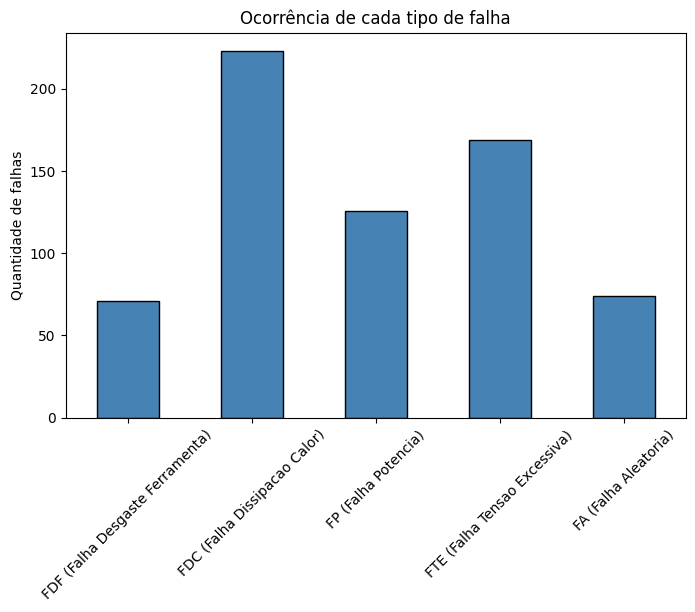

In [ ]:
falhas_totais = tabela_train[colunas_falha].astype(int).sum()

display(falhas_totais)

falhas_totais.plot(kind="bar", figsize=(8,5), color="steelblue", edgecolor="black")
plt.title("Ocorrência de cada tipo de falha")
plt.ylabel("Quantidade de falhas")
plt.xticks(rotation=45)
plt.show()

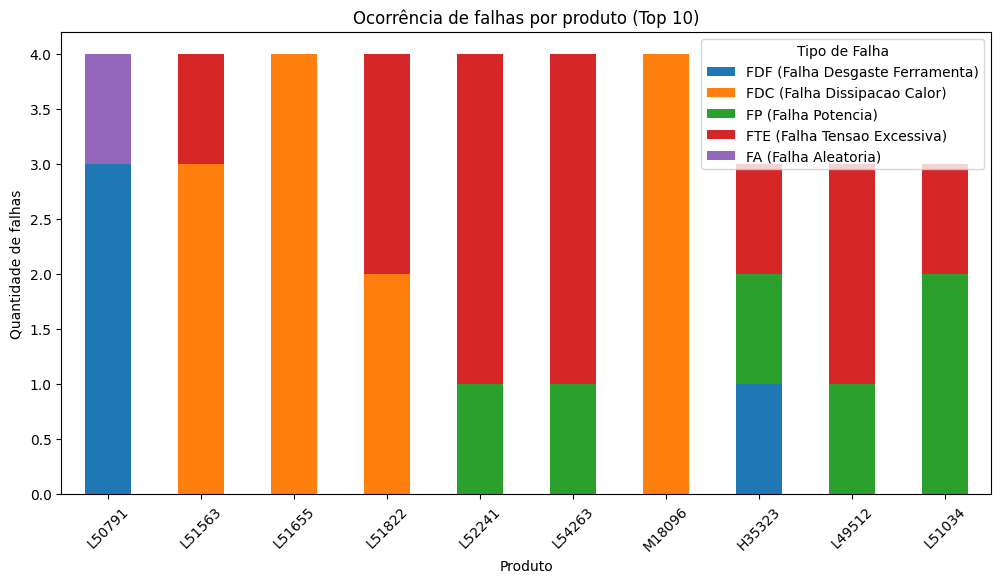

In [ ]:
def plot_stacked_failures(df, colunas_falha, top_n=10):

    df[colunas_falha] = df[colunas_falha].astype(int)

    # cria tabela com contagem de falhas por produto
    falhas_produto = df.groupby("id_produto")[colunas_falha].sum()

    # seleciona os produtos com mais falhas
    falhas_totais = falhas_produto.sum(axis=1).nlargest(top_n).index
    falhas_top = falhas_produto.loc[falhas_totais]

    # gráfico de barras empilhadas
    falhas_top.plot(kind="bar", stacked=True, figsize=(12,6))
    plt.title(f"Ocorrência de falhas por produto (Top {top_n})")
    plt.xlabel("Produto")
    plt.ylabel("Quantidade de falhas")
    plt.xticks(rotation=45)
    plt.legend(title="Tipo de Falha")
    plt.show()

plot_stacked_failures(tabela_train, colunas_falha, top_n=10)

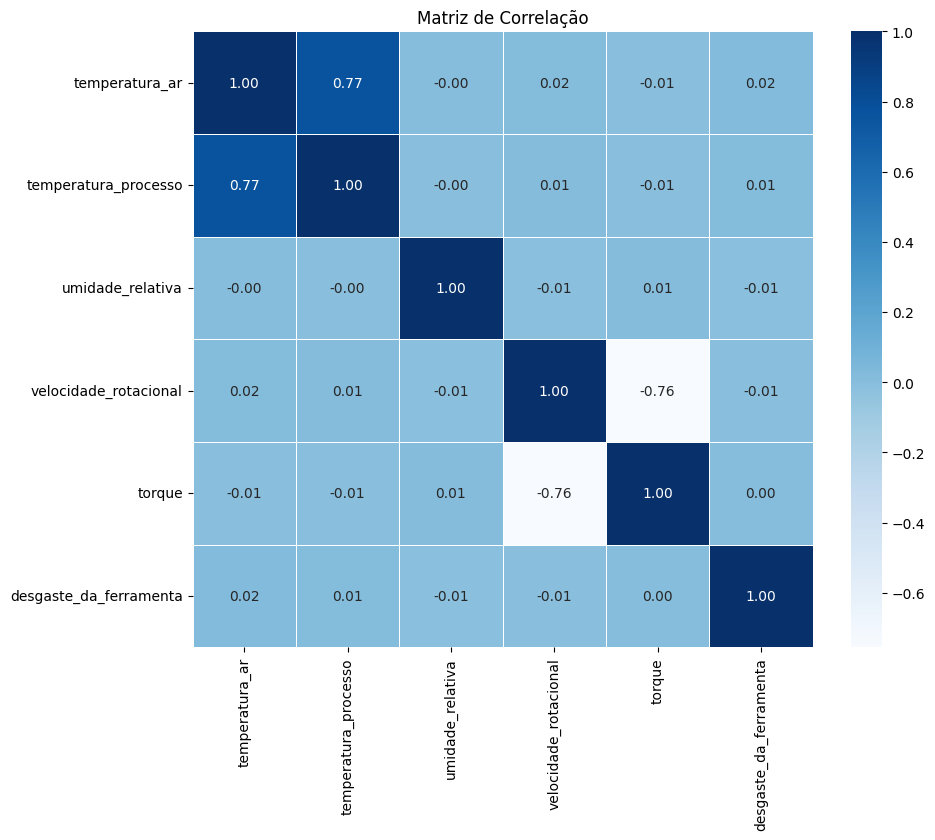

In [ ]:
# Criar tabela de correlação
def plot_correlation_matrix(df):
    corr_df = df[df.select_dtypes(include=['float']).columns]  # Apenas atributos contínuos
    plt.figure(figsize=(10, 8))
    correlation_matrix = corr_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlação')
    plt.show()

plot_correlation_matrix(tabela_train)

### Criar boxplot para analisar os outliers

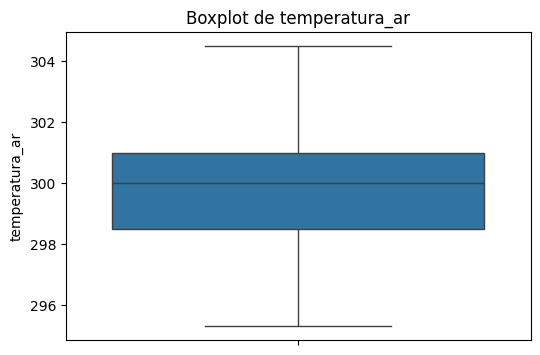

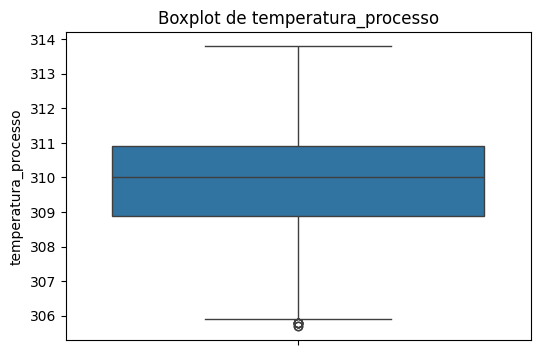

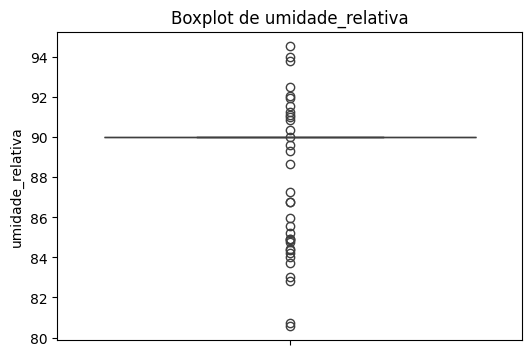

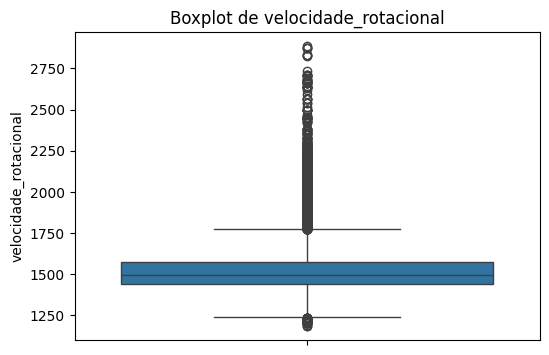

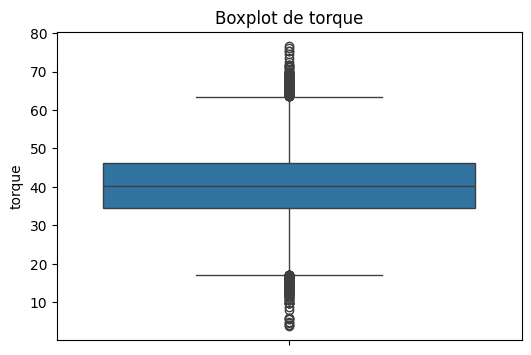

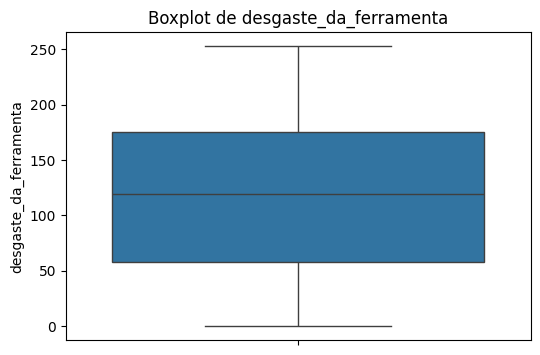

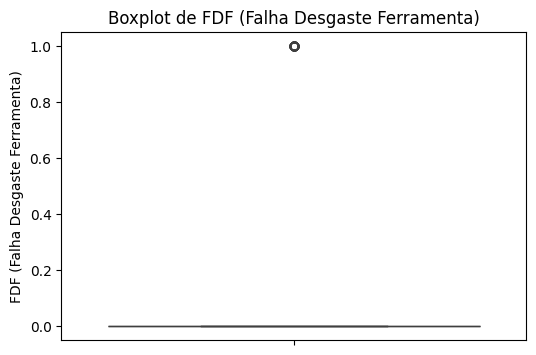

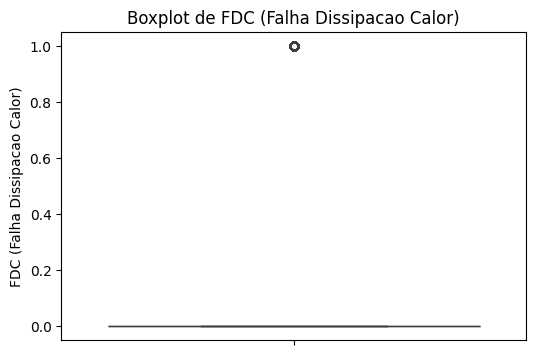

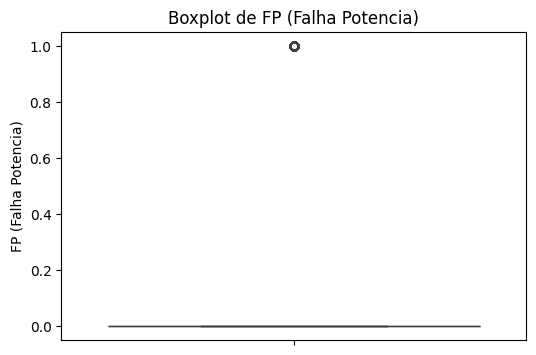

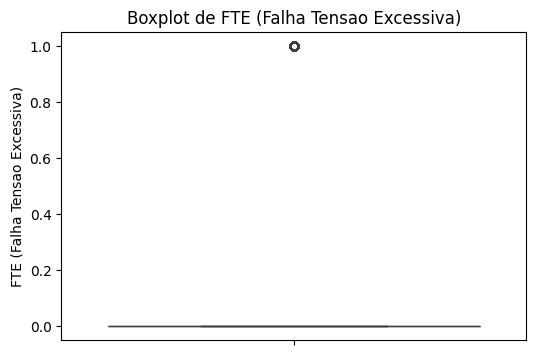

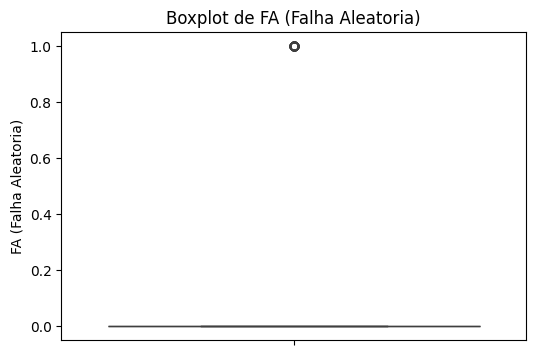

In [ ]:
colunas_numericas = tabela_train.select_dtypes(include=['float64', 'int64']).columns


for coluna in colunas_numericas:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=tabela_train[coluna])
    plt.title(f'Boxplot de {coluna}')
    plt.ylabel(coluna)
    plt.show()

In [ ]:
def remover_outliers(df, coluna_outlier) :
    df_sem_outliers = pd.DataFrame()

    Q1 = df[coluna_outlier].quantile(0.25)
    Q3 = df[coluna_outlier].quantile(0.75)
    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    mediana = df[coluna_outlier].median()

    df[coluna_outlier] = np.where(
        (df[coluna_outlier] < limite_inferior) | (df[coluna_outlier] > limite_superior),
        mediana,
        df[coluna_outlier]
      )

    df_sem_outliers = pd.concat([df_sem_outliers, df])

    return df_sem_outliers

In [ ]:
tabela_train = remover_outliers(tabela_train,"temperatura_processo")
tabela_train = remover_outliers(tabela_train,"umidade_relativa")
tabela_train = remover_outliers(tabela_train,"velocidade_rotacional")
tabela_train = remover_outliers(tabela_train,"torque")

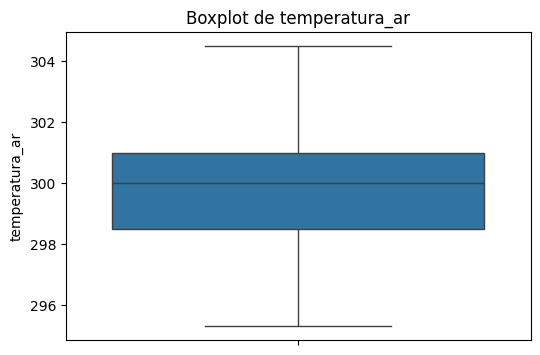

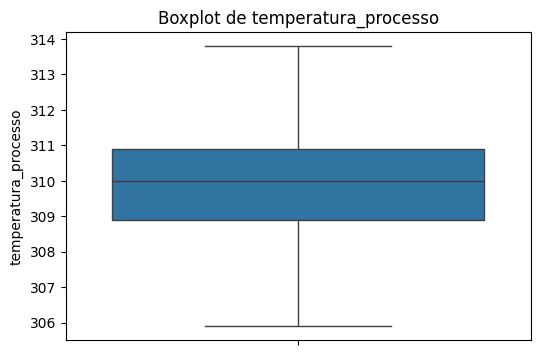

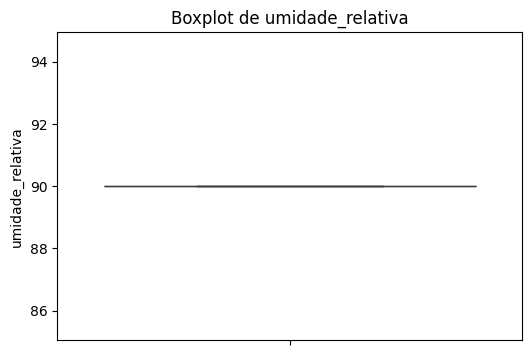

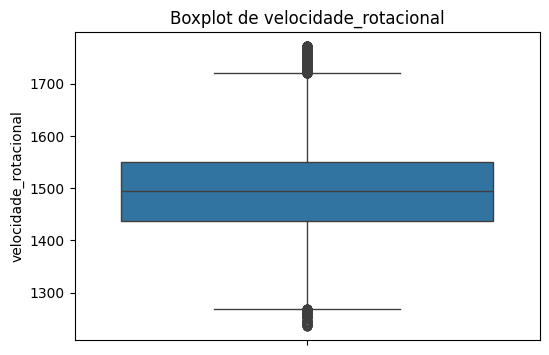

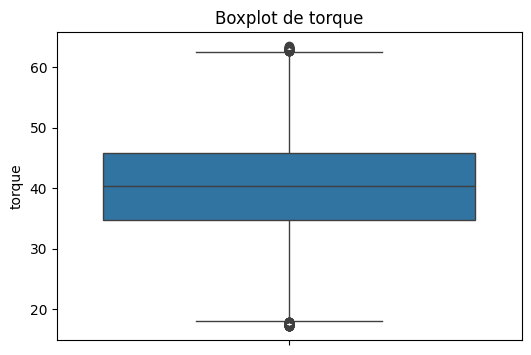

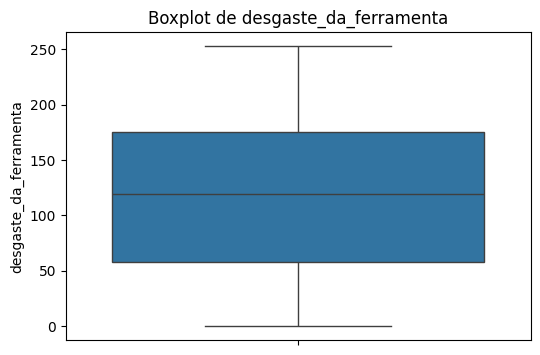

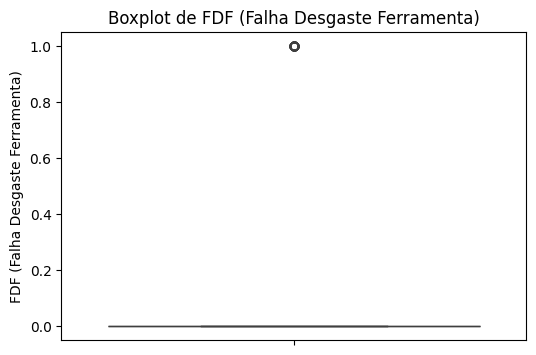

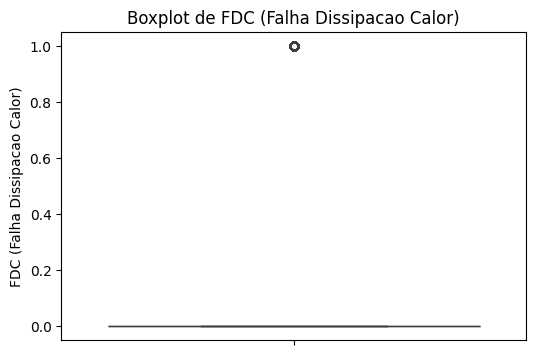

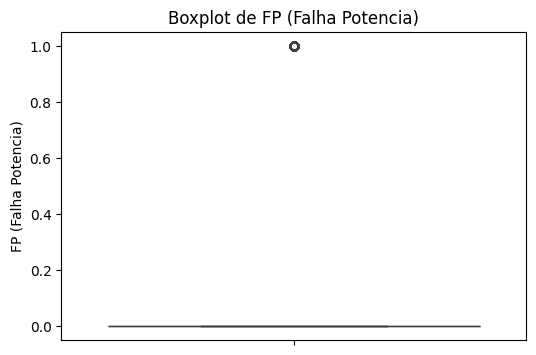

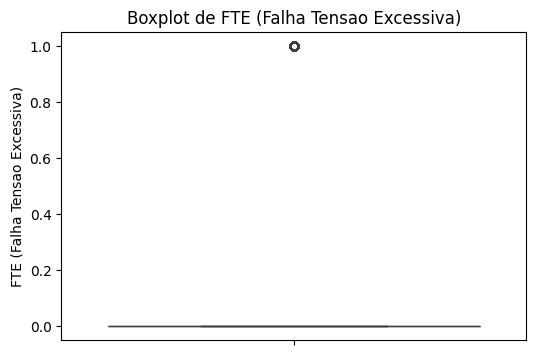

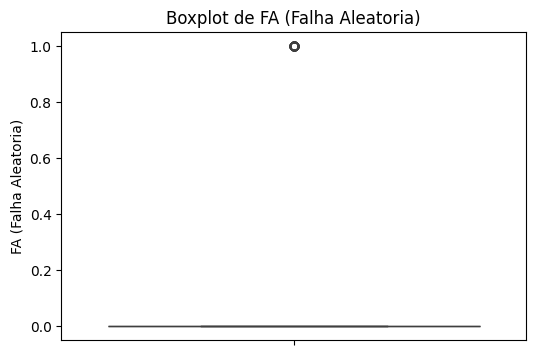

In [ ]:
for coluna in colunas_numericas:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=tabela_train[coluna])
    plt.title(f'Boxplot de {coluna}')
    plt.ylabel(coluna)
    plt.show()

In [ ]:
numerico = ['temperatura_ar', 'temperatura_processo', 'umidade_relativa',
            'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']
categorico = ['id_produto']

In [ ]:
X = tabela_train.drop(columns=colunas_falha).copy()
y = tabela_train[colunas_falha].copy()

In [ ]:
y_aux = (y.sum(axis=1) > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_aux)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerico),
    ]
)

In [ ]:
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42)))
])

In [ ]:
%%time
rf.fit(X_train, y_train)

CPU times: user 11.4 s, sys: 14.4 ms, total: 11.5 s
Wall time: 11.6 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temperatura_ar',
                                                   'temperatura_processo',
                                                   'umidade_relativa',
                                                   'velocidade_rotacional',
                                                   'torque',
                                                   'desgaste_da_ferramenta'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)))])

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
print("===== Classification Report =====")
print(classification_report(y_test, y_pred, target_names=colunas_falha))

===== Classification Report =====
                                 precision    recall  f1-score   support

FDF (Falha Desgaste Ferramenta)       0.00      0.00      0.00        20
   FDC (Falha Dissipacao Calor)       0.50      0.37      0.42        38
            FP (Falha Potencia)       0.00      0.00      0.00        20
   FTE (Falha Tensao Excessiva)       1.00      0.06      0.11        35
           FA (Falha Aleatoria)       0.00      0.00      0.00        19

                      micro avg       0.46      0.12      0.19       132
                      macro avg       0.30      0.09      0.11       132
                   weighted avg       0.41      0.12      0.15       132
                    samples avg       0.00      0.00      0.00       132



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


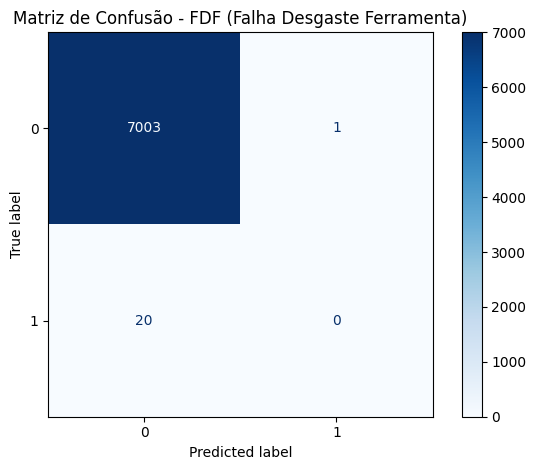

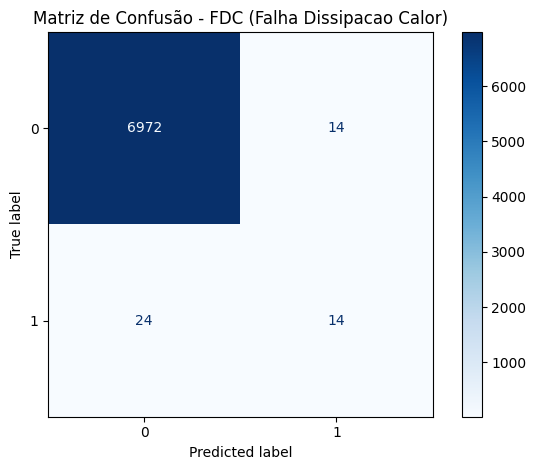

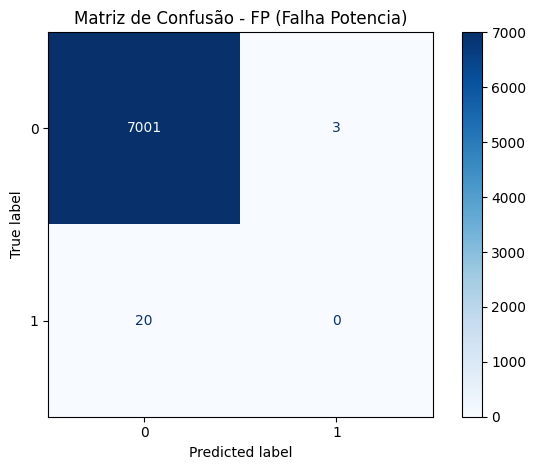

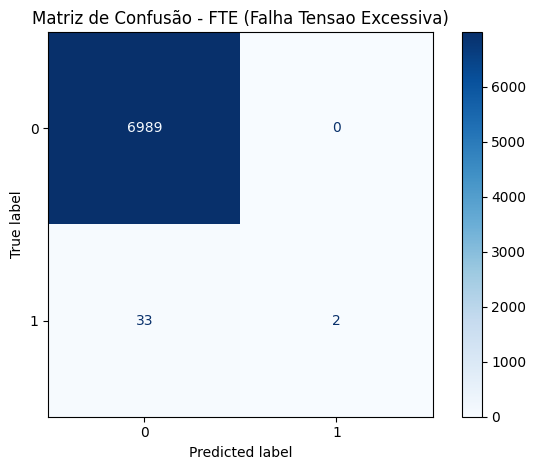

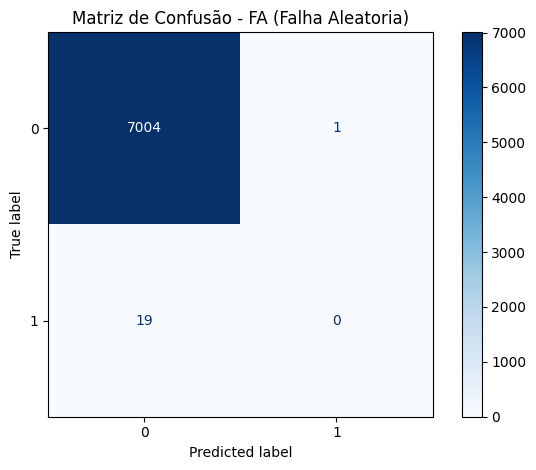

In [ ]:
for i, coluna in enumerate(colunas_falha):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusão - {coluna}")
    plt.tight_layout()
    plt.show()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerico),
    ]
)

In [ ]:
xgb_clf = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

In [ ]:
%%time
xgb_clf.fit(X_train, y_train)

CPU times: user 1.81 s, sys: 95.8 ms, total: 1.91 s
Wall time: 1.12 s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temperatura_ar',
                                                   'temperatura_processo',
                                                   'umidade_relativa',
                                                   'velocidade_rotacional',
                                                   'torque',
                                                   'desgaste_da_ferramenta'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
y_pred = xgb_clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=colunas_falha))

                                 precision    recall  f1-score   support

FDF (Falha Desgaste Ferramenta)       0.00      0.00      0.00        20
   FDC (Falha Dissipacao Calor)       0.45      0.37      0.41        38
            FP (Falha Potencia)       0.11      0.05      0.07        20
   FTE (Falha Tensao Excessiva)       0.55      0.17      0.26        35
           FA (Falha Aleatoria)       0.00      0.00      0.00        19

                      micro avg       0.40      0.16      0.23       132
                      macro avg       0.22      0.12      0.15       132
                   weighted avg       0.29      0.16      0.20       132
                    samples avg       0.00      0.00      0.00       132



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

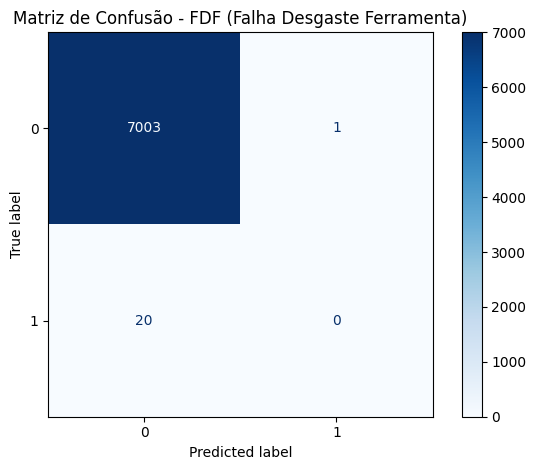

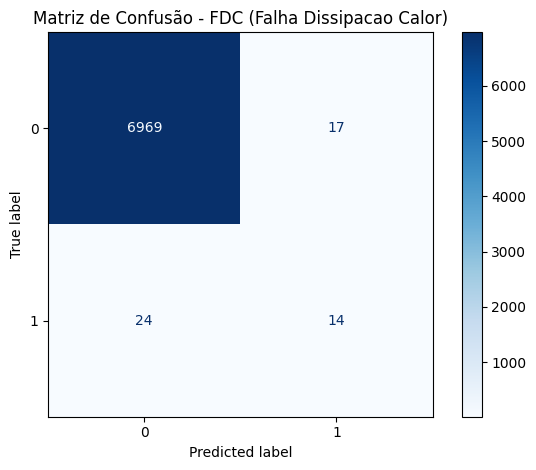

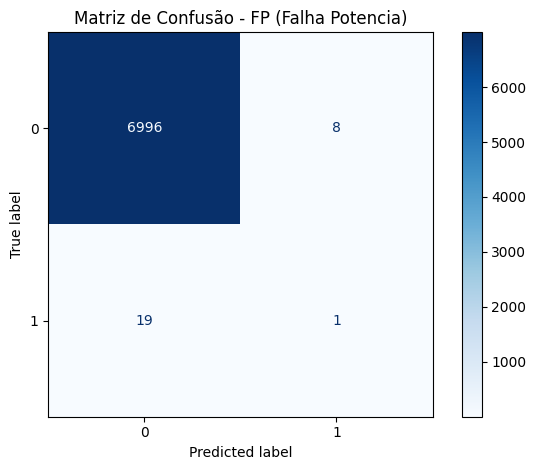

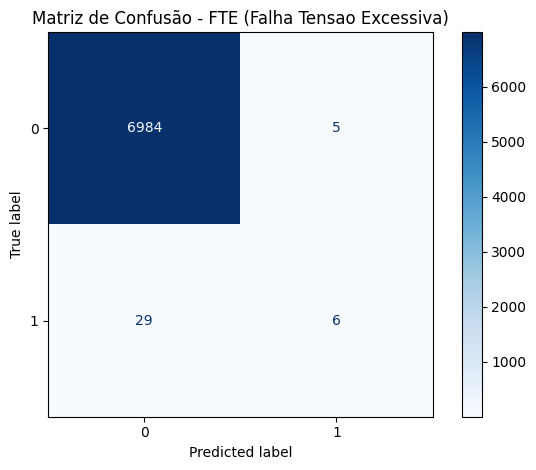

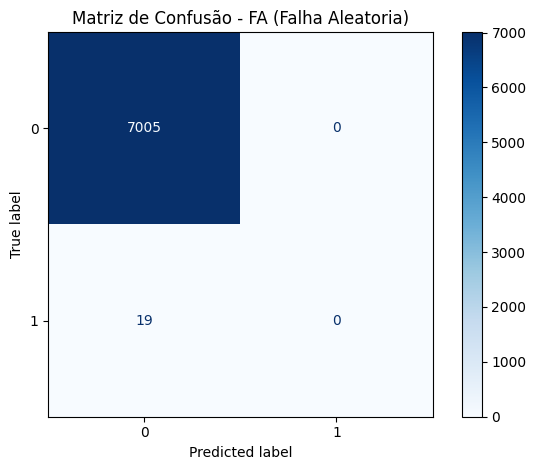

In [ ]:
for i, coluna in enumerate(colunas_falha):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusão - {coluna}")
    plt.tight_layout()
    plt.show()

In [ ]:
X = tabela_train.drop(columns=colunas_falha).copy()
y = tabela_train[colunas_falha].copy()

In [ ]:
y_aux = (y.sum(axis=1) > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_aux)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerico),
    ]
)

In [ ]:
lgb_clf = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_estimators=300,
    learning_rate=0.05,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [ ]:
lgb = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', MultiOutputClassifier(lgb_clf, n_jobs=-1))
])

In [ ]:
%%time
lgb.fit(X_train, y_train)

CPU times: user 140 ms, sys: 17.4 ms, total: 157 ms
Wall time: 16.9 s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temperatura_ar',
                                                   'temperatura_processo',
                                                   'umidade_relativa',
                                                   'velocidade_rotacional',
                                                   'torque',
                                                   'desgaste_da_ferramenta'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=LGBMClassifier(class_weight='balanced',
                                                                learning_rate=0.05,
                                                                n_estimators=300,
                                                                n_jobs=-1,
                                                                objective='binary',
                                                                random_state=42),
                                       n_jobs=-1))])

In [ ]:
y_pred = lgb.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=colunas_falha))

                                 precision    recall  f1-score   support

FDF (Falha Desgaste Ferramenta)       0.00      0.00      0.00        20
   FDC (Falha Dissipacao Calor)       0.37      0.63      0.47        38
            FP (Falha Potencia)       0.18      0.25      0.21        20
   FTE (Falha Tensao Excessiva)       0.28      0.37      0.32        35
           FA (Falha Aleatoria)       0.00      0.00      0.00        19

                      micro avg       0.27      0.32      0.29       132
                      macro avg       0.17      0.25      0.20       132
                   weighted avg       0.21      0.32      0.25       132
                    samples avg       0.01      0.01      0.01       132



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = xgb.XGBClassifier(random_state=42)
lgb_clf = LGBMClassifier(random_state=42)

voting = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb_clf),
        ('lgb', lgb_clf)
    ],
    voting='soft'
)

ensemble = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', MultiOutputClassifier(voting, n_jobs=-1))
])

ensemble.fit(X_train, y_train)



Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temperatura_ar',
                                                   'temperatura_processo',
                                                   'umidade_relativa',
                                                   'velocidade_rotacional',
                                                   'torque',
                                                   'desgaste_da_ferramenta'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=VotingClassifier(estimators=[('rf',
                                                                               RandomForestClassifier(random_state=42)),
                                                                              ('xgb',
                                                                               XGBClassi...
                                                                                             interaction_constraints=None,
                                                                                             learning_rate=None,
                                                                                             max_bin=None,
                                                                                             max_cat_threshold=None,
                                                                                             max_cat_to_onehot=None,
                                                                                             max_delta_step=None,
                                                                                             max_depth=None,
                                                                                             max_leaves=None,
                                                                                             min_child_weight=None,
                                                                                             missing=nan,
                                                                                             monotone_constraints=None,
                                                                                             multi_strategy=None,
                                                                                             n_estimators=None,
                                                                                             n_jobs=None,
                                                                                             num_parallel_tree=None, ...)),
                                                                              ('lgb',
                                                                               LGBMClassifier(random_state=42))],
                                                                  voting='soft'),
                                       n_jobs=-1))])

In [ ]:
y_pred = ensemble.predict(X_test)

print(classification_report(y_test, y_pred, target_names=colunas_falha))

                                 precision    recall  f1-score   support

FDF (Falha Desgaste Ferramenta)       0.00      0.00      0.00        20
   FDC (Falha Dissipacao Calor)       0.53      0.45      0.49        38
            FP (Falha Potencia)       0.09      0.05      0.06        20
   FTE (Falha Tensao Excessiva)       0.50      0.14      0.22        35
           FA (Falha Aleatoria)       0.00      0.00      0.00        19

                      micro avg       0.43      0.17      0.25       132
                      macro avg       0.22      0.13      0.15       132
                   weighted avg       0.30      0.17      0.21       132
                    samples avg       0.00      0.00      0.00       132



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [ ]:
tabela_test = pd.read_csv("bootcamp_test.csv")

In [ ]:
ids = tabela_test["id"].tolist()

In [ ]:
tabela_test.shape

(7173, 9)

In [ ]:
tabela_test.sample(10)

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta
1684,36944,M22715,M,300.3,311.8,90.0,1592,32.1,11
6475,41735,L57161,L,298.7,308.5,90.0,1353,47.0,146
711,35971,L48140,L,295.8,306.5,90.0,1534,37.9,88
2232,37492,H37795,H,298.9,311.2,90.0,1776,24.7,53
1958,37218,L53379,L,300.9,310.9,90.0,1497,43.2,62
4803,40063,L53102,L,300.5,310.3,90.0,1435,48.4,5
2350,37610,M21123,M,301.0,310.6,90.0,1698,34.3,14
3779,39039,L51023,L,302.4,311.2,90.0,1488,60.1,53
3465,38725,L50157,L,300.4,309.3,90.0,1413,50.3,64
6646,41906,H39316,H,298.4,309.2,90.0,1412,45.7,114


In [ ]:
display(tabela_test.isnull().sum())

,0
id,0
id_produto,0
tipo,0
temperatura_ar,0
temperatura_processo,0
umidade_relativa,0
velocidade_rotacional,0
torque,0
desgaste_da_ferramenta,0


In [ ]:
tabela_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173 entries, 0 to 7172
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7173 non-null   int64  
 1   id_produto              7173 non-null   object 
 2   tipo                    7173 non-null   object 
 3   temperatura_ar          7173 non-null   float64
 4   temperatura_processo    7173 non-null   float64
 5   umidade_relativa        7173 non-null   float64
 6   velocidade_rotacional   7173 non-null   int64  
 7   torque                  7173 non-null   float64
 8   desgaste_da_ferramenta  7173 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 504.5+ KB


In [ ]:
tabela_test = substituir_negativos_por_mediana(tabela_test, "temperatura_ar");
tabela_test = remover_nulos(tabela_test, "temperatura_ar");
tabela_test = substituir_negativos_por_mediana(tabela_test, "temperatura_processo");
tabela_test = remover_nulos(tabela_test, "temperatura_processo");
tabela_test = substituir_negativos_por_mediana(tabela_test, "velocidade_rotacional");
tabela_test = remover_nulos(tabela_test, "velocidade_rotacional");
tabela_test = substituir_negativos_por_mediana(tabela_test, "torque");
tabela_test = remover_nulos(tabela_test, "torque");

tabela_test["desgaste_da_ferramenta"] = tabela_test["desgaste_da_ferramenta"].abs();
tabela_test = remover_nulos(tabela_test, "desgaste_da_ferramenta");

In [ ]:
X_test = tabela_test

In [ ]:
def save_predictions_for_submission(ids: list[int], y_pred_probas: list[np.array]) -> pd.DataFrame:
    colunas_falha = [
        "FDF (Falha Desgaste Ferramenta)",
        "FDC (Falha Dissipacao Calor)",
        "FP (Falha Potencia)",
        "FTE (Falha Tensao Excessiva)",
        "FA (Falha Aleatoria)"
    ]

    probs = np.column_stack([y[:, 1] for y in y_pred_probas])

    predictions = pd.DataFrame(probs, columns=colunas_falha)
    predictions.insert(0, "id", ids)
    predictions.to_csv("submission.csv", index=False)

    return predictions

In [ ]:
y_proba_test = ensemble.predict_proba(X_test)

submissiom = save_predictions_for_submission(ids, y_proba_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import requests

headers = {"X-API-Key": "bd0e00c0b328ec2a50d87582019dca56510055b95ca8ae9f85cd21b282c196b7"}
files = {"file": open("submission.csv", "rb")}
params = {"threshold": 0.5}
response = requests.post(
    "http://34.193.187.218:5000//evaluate/multilabel_metrics",
    headers=headers,
    files=files,
    params=params
    )
print(response.json())

{'macro_accuracy': 0.9926948278265719, 'macro_roc_auc': 0.8262125991242784, 'accuracy': [0.9952600027882337, 0.9928900041823505, 0.9920535340861564, 0.9899623588456713, 0.9933082392304475], 'precision': [0.0, 0.8181818181818182, 0.2, 0.6, 0.0], 'recall': [0.0, 0.6728971962616822, 0.018518518518518517, 0.15789473684210525, 0.0], 'f1_score': [0.0, 0.7384615384615385, 0.03389830508474576, 0.25, 0.0], 'roc_auc': [0.8036669213139802, 0.9913009779621248, 0.9072617356786481, 0.9516521065238833, 0.4771812541427557], 'roc': [[[0.0, 0.00014005602240896358, 0.0004201680672268908, 0.0005602240896358543, 0.0030812324929971988, 0.0030812324929971988, 0.00392156862745098, 0.00392156862745098, 0.0065826330532212885, 0.0065826330532212885, 0.00784313725490196, 0.00784313725490196, 0.008263305322128852, 0.008543417366946778, 0.009523809523809525, 0.009523809523809525, 0.013445378151260505, 0.013445378151260505, 0.01834733893557423, 0.01834733893557423, 0.018907563025210083, 0.018907563025210083, 0.02212